In [1]:
import numpy as np
import imageio
import cv2
import glob
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
from skimage.feature import hog
from functools import reduce

%matplotlib inline



In [2]:
# functions used in Advanced Lane Lines
# load Calibration data
dist_pickle = pickle.load( open( "./wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def pipeline_undistort(img):
    """ Undistorts the input image. """
    global mtx, dist
    
    return cv2.undistort(img, mtx, dist, None, mtx)

def binarize(img, thresh=(0, 255), s_thresh=(40, 120), sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sobel x,y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absx = np.abs( sobelx )
    absy = np.abs( sobely )
    
    angles = np.arctan2( absy, absx )
    mag = np.sqrt(sobelx**2+sobely**2)
    scaled_mag = np.uint8( 255*mag/np.max( mag ) )
    binary_output = np.zeros_like( scaled_mag )
    
    hls = cv2.cvtColor( img, cv2.COLOR_BGR2HLS )
    L = hls[:,:,1]
    S = hls[:,:,2]

    binary_output[ ( L > 40 ) &  # Apply lightness threshold filter
               ( ( ( scaled_mag >= 40 ) & # Apply gradient magnitude filter
                 ( scaled_mag <= 255 ) &   
                 ( angles >= 0.8 ) &   # Apply gradient direction filter
                 ( angles <= 1.2 ) ) |
                 ( ( S >  100 ) & # Apply saturation filter
                 ( S <= 255 ) ) ) ] = 1

    return scaled_mag, binary_output

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp(img,tobird=True):
    corners = np.float32([[200,720],[580,460],[705,460],[1130,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    M = cv2.getPerspectiveTransform(src, dst)    
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv

def perspective_transform(img):
    width = img.shape[1]
    height = img.shape[0]
    src = np.array([[(width*0.4, height*0.65),
                        (width*0.6, height*0.65),
                        (width, height),
                        (0, height)]], 
                        dtype=np.float32)
    dst = np.array([[0,0], 
                    [img.shape[1], 0], 
                    [img.shape[1], img.shape[0]],
                    [0, img.shape[0]]],
                    dtype = 'float32')
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_output = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped_output, M, Minv

def warp_binarize_pipeline(undist): 
    test, binary = binarize(undist)
    result, M, Minv  = warp(binary)
    result = region_of_interest(result)
    return result,M,Minv 

def get_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)
    
    # Calculate curvature in pixel-space.
    
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    ## Example values: 1926.74 1908.48
    
    # Convert from pixels to metres.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # Calculate Lane Deviation from center of lane:
    # First we calculate the intercept points at the bottom of our image, then use those to 
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curverad, right_curverad, lane_deviation

def find_lane_lines(binary_warped, debug=False):
   
    if debug == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    l, r, d = get_curvature(leftx, lefty, rightx, righty, ploty, binary_warped.shape)
    
    if debug == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img
    else:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d
    
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = 'Curvature: Left = ' + str(np.round(left_radius, 2)) + ', Right = ' + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (255,255,255), 2)
    deviation_text = 'Lane deviation from center = {:.2f} m'.format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (255,255,255), 2)
        
    return result

In [12]:
# Car Detection Related Funcitons

class HeatHistory():
    def __init__(self):
        self.history = []

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def findBoxes(img, clf, scaler, params = None, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):
   
    # Parameters extraction
    # HOG parameters
    cspace = 'YCrCb'
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    # Spatial parameters
    size = (16, 16)
    # Histogram parameters
    hist_bins = 32
    hist_range = (0, 256)
    
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows        

In [6]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hist_range = dist_pickle["hist_range"]

frames_to_remember = 3
threshhold = 2    

history = HeatHistory()


def video_pipeline(image):
    boxes = findBoxes(image, svc, scaler)
    img_shape = image.shape
    heatmap = add_heat(np.zeros(img_shape), boxes)
    if len(history.history) >= frames_to_remember:
        history.history = history.history[1:]

    history.history.append(heatmap)
    heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
    heatmap = apply_threshold(heat_history, threshhold)
    labels = label(heatmap)

    undistorted = pipeline_undistort(image)
    binary_warped,M,Minv = warp_binarize_pipeline(undistorted)
    left_fitx, right_fitx, ploty, _, _, l, r, d = find_lane_lines(binary_warped)
    lane_lines_img = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)
    
    annotated_img = draw_labeled_bboxes(lane_lines_img, labels)
    
    return annotated_img


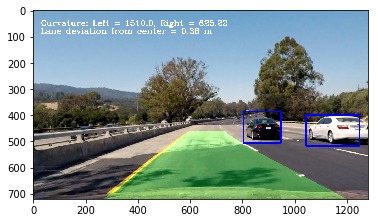

In [14]:
image = mpimg.imread('test_images/test4.jpg')
vis_annotated_img = video_pipeline(image)
plt.imshow(vis_annotated_img)
plt.savefig('./output_images/video_pipeline_test.jpg')

In [15]:

video_output = "output_images/project_video_output.mp4"
vid_clip = VideoFileClip("./project_video.mp4")
frame_output = vid_clip.fl_image(video_pipeline) 
%time frame_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [46:32<00:01,  1.90s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

Wall time: 46min 33s
